In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import pytz

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

la_tz = pytz.timezone('America/Los_Angeles')
format = '%Y-%m-%d'

from sustaingym.envs.evcharging import utils, train_gmm_model

In [3]:
dir = 'sustaingym/sustaingym/data/evcharging/gmms_ev_charging/caltech'

seasons = ['Summer 2019', 'Fall 2019', 'Spring 2020', 'Summer 2021']

periods = [
    (datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][0], format).replace(tzinfo=la_tz),
     datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][1], format).replace(tzinfo=la_tz))
    for season in seasons]

dfs = [utils.get_real_events(period[0], period[1], 'caltech') for period in periods]

dates = [
    '2019-05-01 2019-08-31 30/',
    '2019-09-01 2019-12-31 30/',
    '2020-02-01 2020-05-31 30/',
    '2021-05-01 2021-08-31 30/',
]

gmms = [utils.load_gmm_model('caltech', '')['gmm'] for date in dates]

TypeError: load_gmm_model() missing 2 required positional arguments: 'end' and 'n_components'

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold

components = [5, 10, 20, 30, 40, 50, 60, 75, 100]

def fit_scores(df, components=components):
    dff = train_gmm_model.preprocess(df, filter=True)
    folds = KFold(n_splits=5, shuffle=True, random_state=42)

    oof_scores = []
    for n_c in components:
        gmm = GaussianMixture(n_components=n_c)

        scores = []
        for train_idx, test_idx in folds.split(dff):
            train = dff.iloc[train_idx]
            test = dff.iloc[test_idx]

            gmm.fit(train)
            score = gmm.score(test)
            scores.append(score)
        scores = np.mean(scores)
        oof_scores.append(score)
    return np.array(oof_scores)

scores = {}
for i, season in enumerate(seasons):
    print(season)
    scores[season] = fit_scores(dfs[i])
scores

Summer 2019
Fall 2019
Spring 2020
Summer 2021


{'Summer 2019': array([9.17143886, 9.30229362, 9.35300421, 9.54950373, 9.46140103,
        9.47825028, 9.49120051, 9.53449704, 9.43583472]),
 'Fall 2019': array([8.96557019, 9.30266438, 9.57068015, 9.61921853, 9.62856752,
        9.63388095, 9.61387757, 9.53899689, 9.49583835]),
 'Spring 2020': array([9.02450071, 9.47751126, 9.54893825, 9.5403094 , 9.25865291,
        9.13104618, 8.89856517, 8.32966463, 7.83967563]),
 'Summer 2021': array([ 9.39231444,  8.8955127 ,  9.86685043,  9.95498644, 10.15161606,
        10.02444361, 10.09654295,  9.28471906,  9.30004197])}

In [19]:
for season in seasons:
    print(f'{season} best number of components: {components[scores[season].argmax()]}')

scores_sum = scores['Summer 2019'] + scores['Fall 2019'] + scores['Spring 2020'] + scores['Summer 2021']
print(f'overall best number of components: {components[scores_sum.argmax()]}')

Summer 2019 best number of components: 30
Fall 2019 best number of components: 50
Spring 2020 best number of components: 20
Summer 2021 best number of components: 40
overall best number of components: 30


In [9]:
len(dfs[0]), len(dfs[1]), len(dfs[2]), len(dfs[3])

(3527, 3177, 1269, 1829)

In [23]:
def get_fit_score(i, j):
    # gmm trained on i, tested on j
    # w/o cars staying overnight
    df1 = train_gmm_model.preprocess(dfs[j], filter=True)
    # w/ cars staying overnight
    df2 = train_gmm_model.preprocess(dfs[j], filter=False)

    return gmms[i].score(df1), gmms[i].score(df2)

In [24]:
# x-axis: train years, # y-axis: test year

train_cols = {season: [] for season in seasons}

for i, train_season in enumerate(seasons):
    for j, test_season in enumerate(seasons):
        train_cols[train_season].append(get_fit_score(i, j)[0])

print(train_cols)

{'Summer 2019': [4.234415527056902, 3.2997746318259993, 3.044439373016871, 0.40390034217252213], 'Fall 2019': [-0.2779908212927961, -0.034438724574192926, -0.3517987519811351, -1.3159958196776536], 'Spring 2020': [-1.3325409711033553, -1.310843508182816, -1.3755261161614591, -2.5104645414823814], 'Summer 2021': [-6.512073734829902, -6.511509813960804, -6.706554609644226, -6.428982824240368]}


Text(33.0, 0.5, 'GMM testing period')

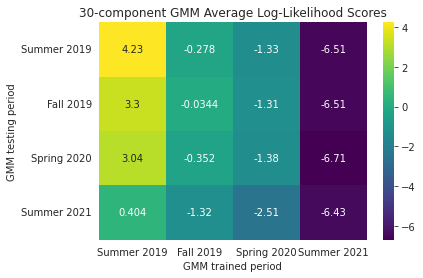

In [26]:
cross_scores = pd.DataFrame(train_cols, index=seasons)

ax = sns.heatmap(cross_scores, cmap='viridis', annot=True, fmt='.3g')
plt.title('30-component GMM Average Log-Likelihood Scores')
plt.xlabel('GMM trained period')
plt.ylabel('GMM testing period')
